In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os import path
import xarray as xr
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.colors as colors
import scipy.stats as stats
from netCDF4 import Dataset
from scipy.stats import pearsonr
import wrf
import sys
from datetime import date

from mmctools.plotting import TaylorDiagram
from mmctools.helper_functions import theta_to_T, lowess_mean, calc_uv, calc_wind, w_s, T_d
from mmctools.wrf.utils import Tower, tsout_seriesReader, write_tslist_file
import matplotlib.gridspec as gridspec
from string import ascii_lowercase
import matplotlib.patches as patches
import skimage.morphology
import matplotlib.colors
sys.path.append('/Users/hawbecke/Code/Python/')
from pydicts.baybreezedict import DetectBayBreeze
from pydicts.obsdict import get_FINO_obs

In [2]:
#wrf_dir    = '/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/'
wrf_dir    = '/Users/hawbecke/Research/Chesapeake/Data/WRF/20190716to20190801/'

restarts   = ['CBB_2019071518', 'CBB_2019071718', 'CBB_2019071918', 'CBB_2019072118', 
              'CBB_2019072318', 'CBB_2019072518', 'CBB_2019072718', 'CBB_2019072918']

wrf_start  = ['2019-07-15 18:00:00','2019-07-17 18:00:00','2019-07-19 18:00:00','2019-07-21 18:00:00',
              '2019-07-23 18:00:00','2019-07-25 18:00:00','2019-07-27 18:00:00','2019-07-29 18:00:00',]


from CBB_case_dict import case_dict
cases = list(case_dict.keys())

ncases   = len(cases)
case_dom = [3]*ncases

# Get WRF data to test:

In [3]:
wrfout_files = sorted(glob.glob('{}{}/{}/wrfout_d0{}*'.format(wrf_dir,cases[0],restarts[0],case_dom[0])))

time_of_interest = '2019-07-16 19:00:00'

for wrfout_file in wrfout_files:
    if time_of_interest.replace(' ','_') in wrfout_file:
        file_of_interest = wrfout_file

wrfout = xr.open_dataset(file_of_interest)
wrfout = np.squeeze(wrfout)
wrfinput = xr.open_dataset('{}{}/{}/wrfinput_d0{}'.format(wrf_dir,cases[0],restarts[0],case_dom[0]))

In [4]:
land_mask  = np.squeeze(wrfinput.LANDMASK)
hgt        = np.squeeze(wrfinput.HGT)
water_mask = land_mask.copy().where(land_mask==0.0) + 1.0
lat  = wrfout.XLAT
lon  = wrfout.XLONG

nx = len(wrfout.west_east)
ny = len(wrfout.south_north)
dx = wrfout.DX/1000.0
dy = wrfout.DY/1000.0
x = np.arange(0,nx)*dx
y = np.arange(0,nx)*dy
xy,yx = np.meshgrid(x,y)

In [5]:
t2   = wrfout.T2.where(land_mask == 1.0)
u10  = wrfout.U10.where(land_mask == 1.0)
v10  = wrfout.V10.where(land_mask == 1.0)
sfcP = wrfout.PSFC.where(land_mask == 1.0)
temp = np.squeeze(wrfout.T)
z_f = (np.squeeze(wrfout.PH) + np.squeeze(wrfout.PHB))/9.8 - np.squeeze(wrfout.HGT)
zs_f = 0.5*(z_f[1:,:,:]+z_f[:-1,:,:])

vel10,dir10 = calc_wind(wrfout,u='U10',v='V10')
vel10 = vel10.where(land_mask == 1.0)
dir10 = dir10.where(land_mask == 1.0)

top_ind = 18
bot_ind = 0

u = wrfout.U[top_ind,:,:].data
v = wrfout.V[top_ind,:,:].data

u = 0.5*(u[:,1:] + u[:,:-1])
v = 0.5*(v[1:,:] + v[:-1,:])
wdir1km = 180. + np.degrees(np.arctan2(u, v))

# Get obs for comparison:

In [6]:
obs_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/'
obs_dir = '/Users/hawbecke/Research/Chesapeake/Data/Obs/'
awos_ds = xr.open_dataset('{}AWOS/AWOS_2019to2020.nc'.format(obs_dir))
asos_ds = xr.open_dataset('{}ASOS/ASOS_2019to2020.nc'.format(obs_dir))
apg_ds  = xr.open_dataset('{}APG/APG_data_2019.nc'.format(obs_dir))

near_shore_stations  = []
inland_station_names = []

near_shore_stations  = ['APG', 'BWI', 'MTN', 'NAK', 'NHK', 'NUI']
inland_station_names = ['ADW', 'CBE', 'CGE', 'CGS', 'CJR', 'DCA', 
                        'ESN', 'FDK', 'GAI', 'GED', 'HGR', 'IAD', 
                        'ILG', 'MIV', 'MRB', 'OXB', 'PHL', 'SBY', 
                        'W29', 'WAL']

apg_stn_list = list(apg_ds.station.data)
for ss,apg_stn in enumerate(apg_stn_list):
    if apg_stn == 'PAA':
        apg_stn_list[ss] = 'APG'
apg_ds = apg_ds.assign_coords({'station': apg_stn_list})

In [7]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
new_cmap = truncate_colormap(plt.cm.terrain, 0.3, 0.8)
new_cmap.set_bad(color='darkblue')

def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return colors.LinearSegmentedColormap('colormap',cdict,1024)

light_cmap = cmap_map(lambda x: x/2 + 0.5, new_cmap)
light_cmap.set_bad(color='lightsteelblue')

def convert_met_to_math(met_deg):
    math_deg = 90.0 - met_deg
    if math_deg < 0.0: math_deg+=360.0
    return math_deg

#met_deg = 270.0
#expected_deg = 180.0
#print('Met:\t\t{}\nExpected:\t{}\ngot:\t\t{}'.format(met_deg,expected_deg,convert_met_to_math(met_deg)))

# Calculate onshore min and max:

In [8]:
# Maxiumum radius to look for water:
max_water_dist = 80.0
low_pct_0 = 95.0
upr_pct_0 = 5.0
max_deg_range = 180.0
show_plots = False

window_len = int(max_water_dist/dx)*2
half_window_len = int(window_len/2)
window_center = int((window_len)/2)
window_dist = ((xy[:window_len+1,:window_len+1] - xy[window_center,window_center])**2 + 
               (yx[:window_len+1,:window_len+1] - yx[window_center,window_center])**2)**0.5
window_dist[np.where(window_dist > max_water_dist)] = np.nan
window_filter = window_dist / window_dist

window_x,window_y = np.meshgrid(np.arange(0,np.shape(window_dist)[1]+1)*dy - max_water_dist - 1.5,
                                np.arange(0,np.shape(window_dist)[0]+1)*dx - max_water_dist - 1.5)

window_deg = -1*(180.0*np.arctan(((yx[:window_len+1,:window_len+1] - yx[window_center,window_center])/
                     (xy[:window_len+1,:window_len+1] - xy[window_center,window_center])))/(np.pi) - 90.0)
window_deg[:,:half_window_len] = window_deg[:,:half_window_len] + 180.0
window_deg[np.where(np.isnan(window_dist))] = np.nan

math_deg = 180.0*np.arctan(((yx[:window_len+1,:window_len+1] - yx[window_center,window_center])/
                     (xy[:window_len+1,:window_len+1] - xy[window_center,window_center])))/(np.pi)
math_deg[:,:half_window_len] = math_deg[:,:half_window_len] + 180.0
math_deg[:half_window_len,half_window_len:] = 360 + math_deg[:half_window_len,half_window_len:]
math_deg[np.where(np.isnan(window_dist))] = np.nan


onshore_min = np.zeros((ny,nx))*np.nan
onshore_max = np.zeros((ny,nx))*np.nan
for ii in np.arange(half_window_len,nx-half_window_len):
    for jj in np.arange(half_window_len,ny-half_window_len): 
#for ii in np.arange(125,126): #98
#    for jj in np.arange(85,86): #87
        if land_mask[jj,ii] == 1.0:
            loc_water_mask = water_mask[jj-half_window_len:jj+half_window_len+1, ii-half_window_len:ii+half_window_len+1]
            dist_water = loc_water_mask * window_dist
            deg_water  = loc_water_mask * window_deg

            # Break down the water bodies into groups:
            water_bodies = skimage.morphology.label(~np.isnan(deg_water)).astype(np.float32)
            water_bodies[water_bodies==0.0] = np.nan
            
            water_body_size = {}
            water_body_dist = {}
            min_water_distance = 999.9
            closest_water_body = 0.0
            
            # If we have water bodies to check, enter loop:
            if ~np.all(np.isnan(water_bodies)): 
                for i in np.arange(1.0,np.nanmax(water_bodies)+1.0): # Loop over all identified water bodies
                    water_size = len(water_bodies[water_bodies==i])
                    if water_size < 8: # Only check for large bodies
                        water_bodies[water_bodies==i] = np.nan
                    else:
                        water_body_size[i] = water_size
                        water_body = water_bodies.copy()
                        water_body[water_bodies!=i] = np.nan # Check only this water body
                        water_body[~np.isnan(water_body)] = 1.0 # Set values to 1 to get mask for distance calculation
                        water_body_min_dist = np.nanpercentile(water_body*dist_water,50)
                        water_body_dist[i] = water_body_min_dist

                # Small water bodies were removed, check to see if there are any large ones:
                if ~np.all(np.isnan(water_bodies)):
                    # Find the largest and closest water bodies:
                    largest_water_body = max(water_body_size,key=water_body_size.get)
                    water_body_id = largest_water_body
                    # Loop over all other water bodies
                    for i in water_body_size.keys():
                        if i != water_body_id:
                            # Check to see if this water body is still relatively large:
                            if water_body_size[i] >= 0.5*water_body_size[water_body_id]:
                                # Assign this the same water body ID
                                water_bodies[water_bodies==i] = water_body_id
                                
                    # Set the selected water body (bodies) to 1.0 for masking
                    water_bodies[water_bodies==water_body_id] = 1.0

                    # Multiply water body mask by direction to water:
                    deg_water *= water_bodies

                    # Check to see if there are negative and positive values in the same water body:
                    deg_range = float(np.nanmax(deg_water)) - float(np.nanmin(deg_water))
                    if deg_range > 300:
                        deg_water[np.where(deg_water>300)] -= 360.0
                        
                    # Set limits for upper and lower bounds.
                    # If range is too big (> max_deg_range) then we iterate by 5 degrees
                    # ... on the upper and lower limits until the range is sufficient.
                    if np.nanmax(water_bodies) > 0:
                        good_lims = False
                        low_pct = low_pct_0
                        upr_pct = upr_pct_0
                        while good_lims == False:
                            lowr_lim = np.nanpercentile(deg_water,low_pct)
                            uppr_lim = np.nanpercentile(deg_water,upr_pct)
                            if lowr_lim - uppr_lim < max_deg_range:
                                good_lims = True
                            else:
                                low_pct -= 5.0
                                upr_pct += 5.0                                
                    else: # Set limits to nan when water_bodies is all nan
                        lowr_lim = np.nan
                        uppr_lim = np.nan
                        
                    onshore_min[jj,ii] = uppr_lim 
                    onshore_max[jj,ii] = lowr_lim


                if show_plots:
                    lwr_xe = max_water_dist*np.cos(np.radians(convert_met_to_math(lowr_lim)))
                    lwr_ye = max_water_dist*np.sin(np.radians(convert_met_to_math(lowr_lim)))
                    upr_xe = max_water_dist*np.cos(np.radians(convert_met_to_math(uppr_lim)))
                    upr_ye = max_water_dist*np.sin(np.radians(convert_met_to_math(uppr_lim)))

                    mid_xe = max_water_dist*np.cos(np.radians(convert_met_to_math(np.nanmedian(deg_water))))
                    mid_ye = max_water_dist*np.sin(np.radians(convert_met_to_math(np.nanmedian(deg_water))))

                    fig = plt.figure(figsize=(12,9))
                    lm_pltF = plt.subplot2grid((2,2),(0,0),aspect='equal')
                    plt_landmask = lm_pltF.pcolormesh(lon,lat,land_mask.where(land_mask==0.0))#,levels=[0.5],colors='k')
                    lm_pltF.scatter(lon[jj,ii],lat[jj,ii],facecolor='b',marker='*',s=200)
                    lm_pltF.tick_params(labelsize=15)
                    lm_pltF.set_xlabel('Longitude',size=18)
                    lm_pltF.set_ylabel('Latitude',size=18)

                    lm_plt = plt.subplot2grid((2,2),(0,1),aspect='equal')
                    plt_landmask = lm_plt.pcolormesh(window_x,window_y,loc_water_mask,norm=Normalize(0,max_water_dist))
                    plt.colorbar(plt_landmask,ax=lm_plt)
                    lm_plt.scatter(0,0,facecolor='b',marker='*',s=400)
                    lm_plt.set_xlim(np.nanmin(window_x)-5.0,np.nanmax(window_x)+5.0)
                    lm_plt.set_ylim(np.nanmin(window_y)-5.0,np.nanmax(window_y)+5.0)
                    lm_plt.tick_params(labelsize=15)
                    lm_plt.set_ylabel('Distance [km]',size=18)

                    dist_plt = plt.subplot2grid((2,2),(1,0),aspect='equal')
                    dist_plt_cm = dist_plt.pcolormesh(window_x,window_y,dist_water,norm=Normalize(0,max_water_dist))
                    plt.colorbar(dist_plt_cm,ax=dist_plt)
                    dist_plt.scatter(0,0,facecolor='b',marker='*',s=400)
                    dist_plt.set_xlim(np.nanmin(window_x)-5.0,np.nanmax(window_x)+5.0)
                    dist_plt.set_ylim(np.nanmin(window_y)-5.0,np.nanmax(window_y)+5.0)
                    dist_plt.tick_params(labelsize=15)
                    dist_plt.set_xlabel('Distance [km]',size=18)
                    dist_plt.set_ylabel('Distance [km]',size=18)

                    deg_plt = plt.subplot2grid((2,2),(1,1),aspect='equal')
                    deg_plt_cm = deg_plt.pcolormesh(window_x,window_y,deg_water)#,norm=Normalize(0,360))
                    plt.colorbar(deg_plt_cm,ax=deg_plt)
                    deg_plt.plot([0,lwr_xe,upr_xe,0],[0,lwr_ye,upr_ye,0],c='r')
                    deg_plt.plot([0,mid_xe],[0,mid_ye],c='g')
                    deg_plt.scatter(0,0,facecolor='b',marker='*',s=400,zorder=5)
                    ##ax[0].plot([0,upr_xe],[0,upr_ye],c='r')
                    #deg_plt = ax[1].pcolormesh(window_x,window_y,deg_water)#,norm=Normalize(0,360))
                    #plt.colorbar(deg_plt,ax=ax[1])
                    deg_plt.set_xlim(np.nanmin(window_x)-5.0,np.nanmax(window_x)+5.0)
                    deg_plt.set_ylim(np.nanmin(window_y)-5.0,np.nanmax(window_y)+5.0)
                    deg_plt.tick_params(labelsize=15)
                    deg_plt.set_xlabel('Distance [km]',size=18)
                    plt.show()
                    wefwef


/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


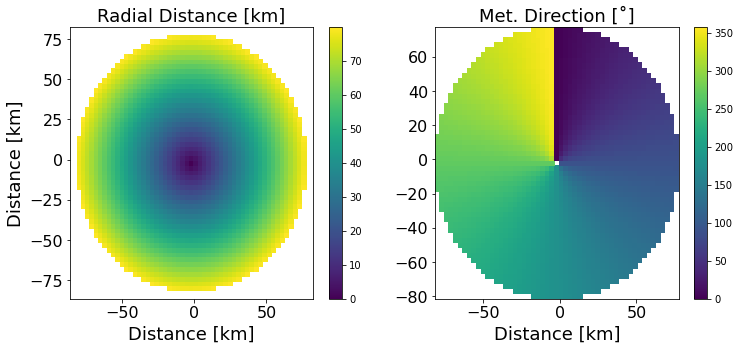

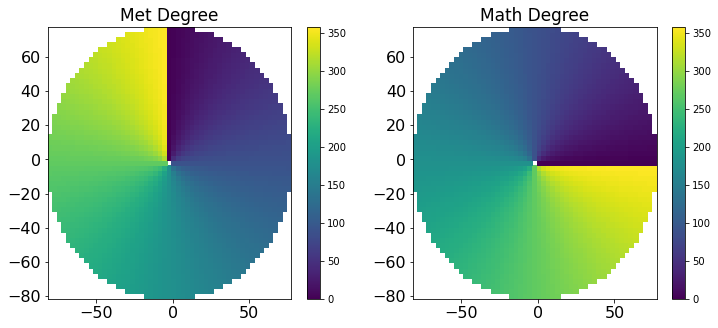

In [9]:
fig,ax = plt.subplots(ncols=2,figsize=(12,5))
dist_plt = ax[0].pcolormesh(window_x,window_y,window_dist)
plt.colorbar(dist_plt,ax=ax[0])
ax[0].set_xlim(np.min(window_x)-5,np.max(window_x)+5)
ax[0].set_ylim(np.min(window_y)-5,np.max(window_y)+5)
deg_plt = ax[1].pcolormesh(window_x,window_y,window_deg)
plt.colorbar(deg_plt,ax=ax[1])
ax[0].tick_params(labelsize=16)
ax[0].set_title('Radial Distance [km]',size=18)
ax[0].set_xlabel('Distance [km]',size=18)
ax[0].set_ylabel('Distance [km]',size=18)
ax[1].tick_params(labelsize=16)
ax[1].set_title('Met. Direction [˚]',size=18)
ax[1].set_xlabel('Distance [km]',size=18)
plt.show()




fig,ax = plt.subplots(ncols=2,figsize=(12,5))
dist_plt = ax[0].pcolormesh(window_x,window_y,window_deg)
plt.colorbar(dist_plt,ax=ax[0])
ax[0].set_title('Met Degree',size=17)
deg_plt = ax[1].pcolormesh(window_x,window_y,math_deg)
plt.colorbar(deg_plt,ax=ax[1])
ax[1].set_title('Math Degree',size=17)
ax[0].tick_params(labelsize=16)
ax[1].tick_params(labelsize=16)
plt.show()


/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


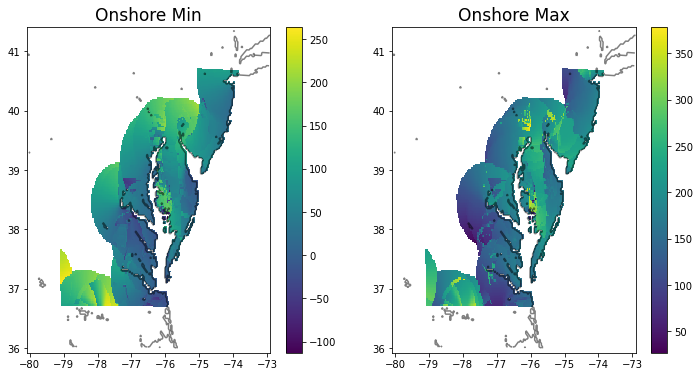

In [10]:
fig,ax = plt.subplots(ncols=2,figsize=(12,6))
dist_plt = ax[0].pcolormesh(lon,lat,onshore_min)
plt.colorbar(dist_plt,ax=ax[0])
ax[0].contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
ax[0].set_title('Onshore Min',size=17)
deg_plt = ax[1].pcolormesh(lon,lat,onshore_max)
plt.colorbar(deg_plt,ax=ax[1])
ax[1].contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
ax[1].set_title('Onshore Max',size=17)
plt.show()

# Check onshore min/max with what was determined in previous study:

/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


Station: APG
	Onshore min - Old: 50.000	New: 59.160
	Onshore max - Old: 200.000	New: 213.203
Station: BWI
	Onshore min - Old: 60.000	New: 56.241
	Onshore max - Old: 160.000	New: 163.771
Station: MTN
	Onshore min - Old: 70.000	New: 73.527
	Onshore max - Old: 190.000	New: 185.367
Station: NAK
	Onshore min - Old: 20.000	New: 14.797
	Onshore max - Old: 190.000	New: 180.000
Station: NHK
	Onshore min - Old: -10.000	New: 7.893
	Onshore max - Old: 170.000	New: 185.044
Station: NUI
	Onshore min - Old: 0.000	New: 11.310
	Onshore max - Old: 150.000	New: 177.025


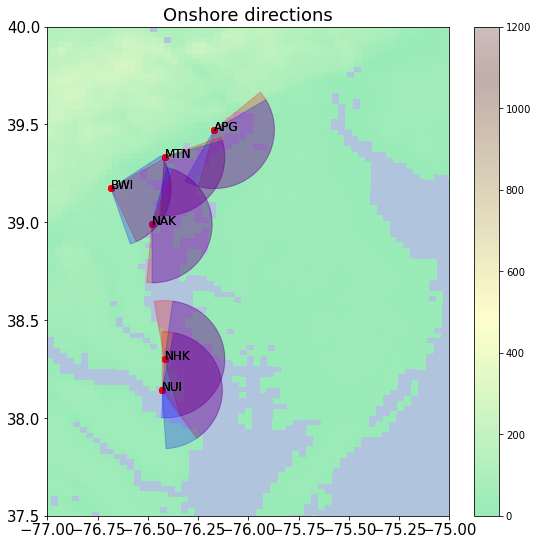

In [11]:
fig = plt.figure(figsize=(9,9))
hgt = hgt.where(land_mask == 1.0)
#hgt[np.where(land_mask==0.0)] = -100
plt.pcolormesh(lon,lat,hgt,
               cmap=light_cmap,
               norm=Normalize(0,1200))
plt.colorbar()
plt.tick_params(labelsize=15)
plt.title('Onshore directions',size=18)

for ss,stn in enumerate(near_shore_stations):
    #if stn == 'APG':
    #    stn_ds = apg_ds.sel(station=stn)
    if stn in awos_ds.station:
        stn_ds = awos_ds.sel(station=stn)
    elif stn in asos_ds.station:
        stn_ds = asos_ds.sel(station=stn)
    stn_lat = stn_ds.lat.data
    stn_lon = stn_ds.lon.data
    dist_from_stn = ((lon-stn_lon)**2 + (lat-stn_lat)**2)**0.5
    stn_j,stn_i = np.where(dist_from_stn == np.nanmin(dist_from_stn))
    stn_j = int(stn_j)
    stn_i = int(stn_i)
    print('Station: {}'.format(stn))
    print('\tOnshore min - Old: {0:4.3f}\tNew: {1:4.3f}'.format(stn_ds.onshore_min.data,onshore_min[stn_j,stn_i]))
    print('\tOnshore max - Old: {0:4.3f}\tNew: {1:4.3f}'.format(stn_ds.onshore_max.data,onshore_max[stn_j,stn_i]))
    

    x, y = stn_lon,stn_lat
    plt.scatter(x,y,c='r')
    for rad in ['old','new']:
        if rad == 'old':
            pts  = np.arange(stn_ds.onshore_min.data,stn_ds.onshore_max.data,5.0)
            fill_c = 'r'
        else:
            pts  = np.arange(onshore_min[stn_j,stn_i],onshore_max[stn_j,stn_i],5.0)
            fill_c = 'b'
            
        npts = pts.size
        fill_x = [x]
        fill_y = [y]
        plt.scatter(x,y,c='r')
        for dd,wdir in enumerate(pts):
            d = 270.0 - wdir    # Convert met degrees to polar
            plt_dist = -0.3 # Met degrees are FROM dir... need negative distance!
            fill_x.append(x+plt_dist*np.cos(np.radians(d)))
            fill_y.append(y+plt_dist*np.sin(np.radians(d)))

        plt.fill(fill_x, fill_y,alpha=0.25,lw=None,color=fill_c,zorder=2)
        plt.text(x,y,stn,size=12)
plt.xlim(-77.0,-75.0)
plt.ylim(37.5,40.0)
plt.show()

In [12]:
def spatial_breeze_check(onshore_min,
                         onshore_max,
                         wrfout,
                         land_mask=None,
                         dt_calc='vertical',
                         wdir_check='vertical'):
    
    if land_mask is None:
        land_mask = wrfout.LANDMASK
    vel10,dir10 = calc_wind(wrfout,u='U10',v='V10')
    vel10 = vel10.where(land_mask == 1.0)
    dir10 = dir10.where(land_mask == 1.0)
    
    onshore_winds = dir10.where((dir10 >= onshore_min) & (dir10 <= onshore_max))
    #onshore_winds /= onshore_winds
    onshore_winds = onshore_winds.fillna(0.0)
    
    top_ind = 18
    bot_ind = 0

    dU = vel10.where(~np.isnan(onshore_min))
    if wdir_check == 'smoothed':
        smooth_dir = dir10.copy()
        h_window = 15
    elif wdir_check == 'vertical':
        u = wrfout.U[top_ind,:,:].data
        v = wrfout.V[top_ind,:,:].data

        u = 0.5*(u[:,1:] + u[:,:-1])
        v = 0.5*(v[1:,:] + v[:-1,:])
        wdir1km = 180. + np.degrees(np.arctan2(u, v))

    temp = np.squeeze(wrfout.T)
    if dt_calc == 'vertical':
        bb_temp = temp.copy().where(~np.isnan(onshore_min))
        dT = (bb_temp[top_ind,:,:] - bb_temp[bot_ind,:,:]) / (zs_f[top_ind,:,:] - zs_f[bot_ind,:,:])
    elif dt_calc == 'horizontal':
        t2 = wrfout.T2.where(land_mask == 1.0)
        dT = t2.where(~np.isnan(onshore_min))

    good_wind_dir = onshore_winds.copy()
    window_start_i = min(np.where(~np.isnan(onshore_min))[1])
    window_start_j = min(np.where(~np.isnan(onshore_min))[0])
    for ii in np.arange(window_start_i,nx-window_start_i):
        for jj in np.arange(window_start_j,ny-window_start_j):
            
            if ~np.isnan(dU[jj,ii]):
                U_window = vel10[jj-1:jj+2,ii-1:ii+2].data.flatten()
                dU_window = vel10[jj,ii].data - U_window
                dU_window[np.where(dU_window<=0.0)] = np.nan
                if np.count_nonzero(np.isnan(dU_window)) > 8:
                    dU[jj,ii] = np.nan
                else:
                    dU[jj,ii] = np.nanmean(dU_window)
                
            if dt_calc == 'horizontal':
                if ~np.isnan(dT[jj,ii]):
                    T_window = t2[jj-1:jj+2,ii-1:ii+2].data.flatten()
                    dT_window = t2[jj,ii].data - T_window
                    dT_window[np.where(dT_window>=0.0)] = np.nan
                    if np.count_nonzero(np.isnan(dT_window)) > 8:
                        dT[jj,ii] = np.nan
                    else:
                        dT[jj,ii] = np.nanmean(dT_window)


            if wdir_check == 'smoothed':
                if ((ii >= h_window) & (jj >= h_window)) & ((ii <= nx-h_window) & (jj <= ny-h_window)):
                    dir_window = dir10.data[jj-h_window:jj+h_window+1,ii-h_window:ii+h_window+1].copy()
                    dir_window_range = np.nanmax(dir_window) - np.nanmin(dir_window)
                    if dir_window_range > 300.0:
                        #print(dir_window)
                        if np.nanmedian(dir_window) < 180.0:
                            dir_window[dir_window >= 270.0] -= 360.0
                        else:
                            dir_window[dir_window <= 90.0] += 360.0
                    smooth_dir[jj,ii] = np.nanmean(dir_window)
                else:
                    smooth_dir[jj,ii] = np.nan
            
            if onshore_winds[jj,ii] > 0.0:
                if wdir_check == 'smoothed':
                    is_onshore = (smooth_dir[jj,ii] > onshore_min[jj,ii]) & (smooth_dir[jj,ii] < onshore_max[jj,ii])
                    meso_wind  = smooth_dir[jj,ii]
                else:
                    is_onshore = (wdir1km[jj,ii] > onshore_min[jj,ii]) & (wdir1km[jj,ii] < onshore_max[jj,ii])
                    meso_wind = wdir1km[jj,ii]
                local_wind = dir10[jj,ii]
                wind_diff = np.abs(meso_wind - local_wind)
                if wind_diff > 200.0:
                    if meso_wind > local_wind:
                        local_wind += 360.0
                    else:
                        meso_wind += 360.0
                    wind_diff = np.abs(meso_wind - local_wind)
                is_different = wind_diff >= 30.0
                if is_onshore and ~is_different:
                    good_wind_dir[jj,ii] = 0.0
    
    
    bay_breeze_area = land_mask.copy()
    bay_breeze_area = bay_breeze_area.where(land_mask==1.0).data
    bay_breeze_area = bay_breeze_area*0.0
    bay_breeze_area[good_wind_dir > 0.0] += 1.0
    bay_breeze_area[dT >= 0.0001] += 1.0
    bay_breeze_area[dU > 0.5] += 1.0

    
    bay_breeze_detection_dict = {   'breeze':bay_breeze_area,
                                 'good_wdir':good_wind_dir,
                                        'dT':dT,
                                        'dU':dU}
    
    
    
    return bay_breeze_detection_dict

In [37]:
def convert_breeze_dict_to_xr(breeze_dict):
    for kk,key in enumerate(breeze_dict.keys()):
        if key == 'breeze':
            var = breeze_dict['good_wdir'].copy()
            var.data = breeze_dict[key]
        else:
            var = breeze_dict[key]
            var.name = key
        if kk == 0:
            ds = xr.Dataset({key: var})
        else:
            ds = xr.merge([ds,var])
            
    ds = ds.expand_dims('datetime')
    dtime = ds.XTIME.expand_dims('datetime')
    ds = ds.drop('XTIME')
    ds['datetime'] = dtime
    return(ds)

/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in less_equal
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/hawbecke/.conda/envs/pyhawbeck/lib/

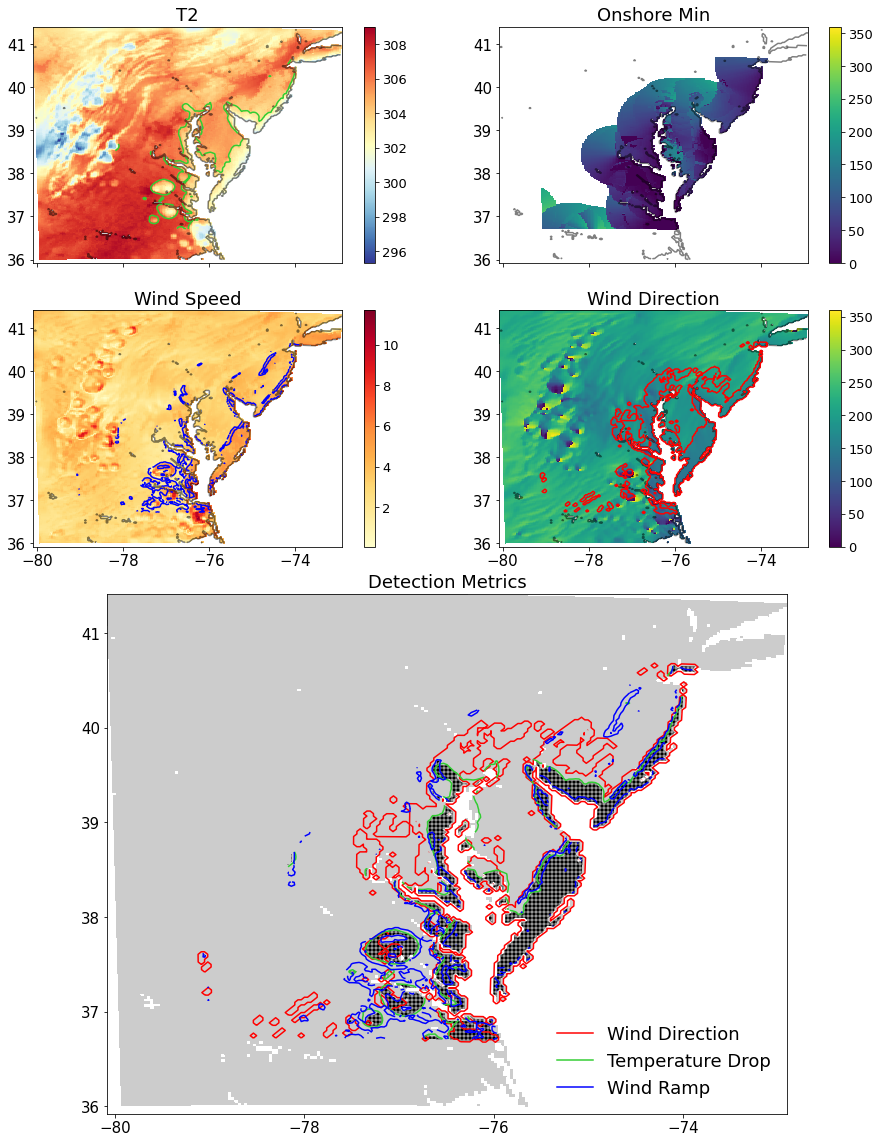

/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in less_equal
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/hawbecke/.conda/envs/pyhawbeck/lib/

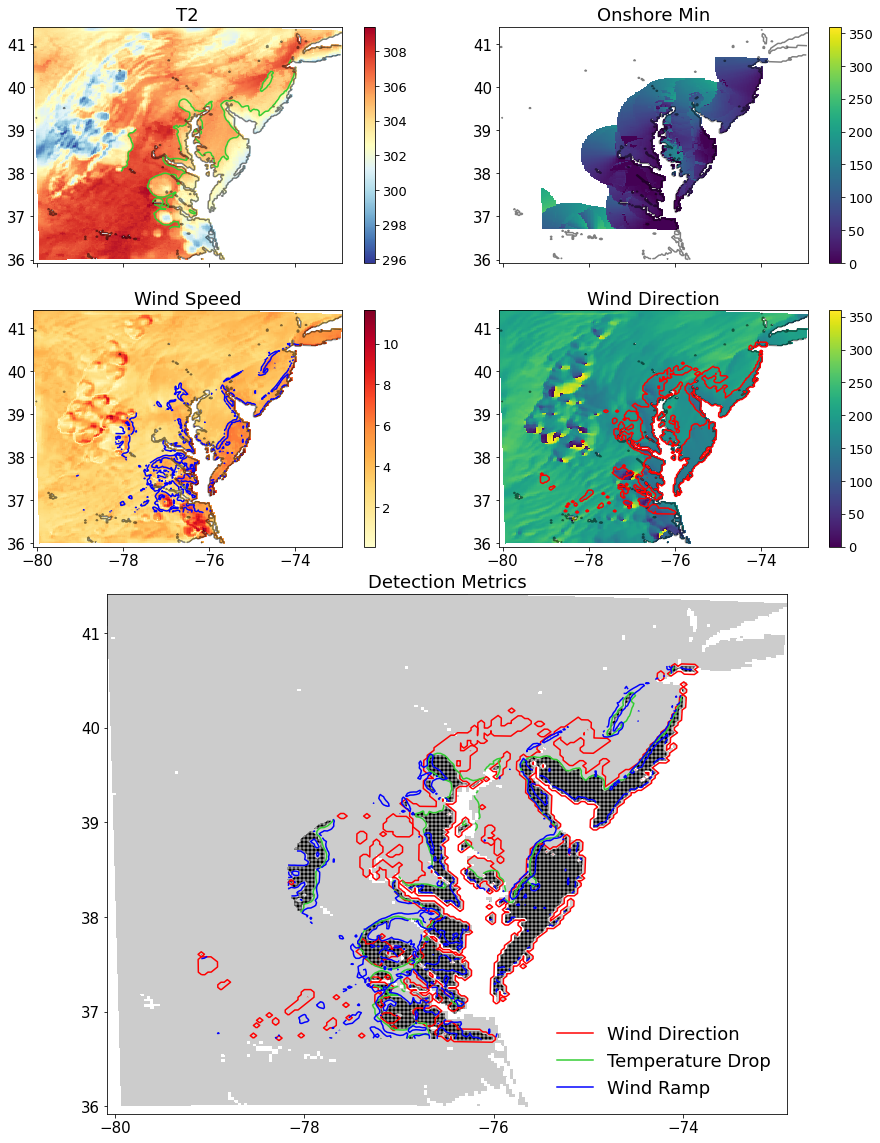

/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in less_equal
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/hawbecke/.conda/envs/pyhawbeck/lib/

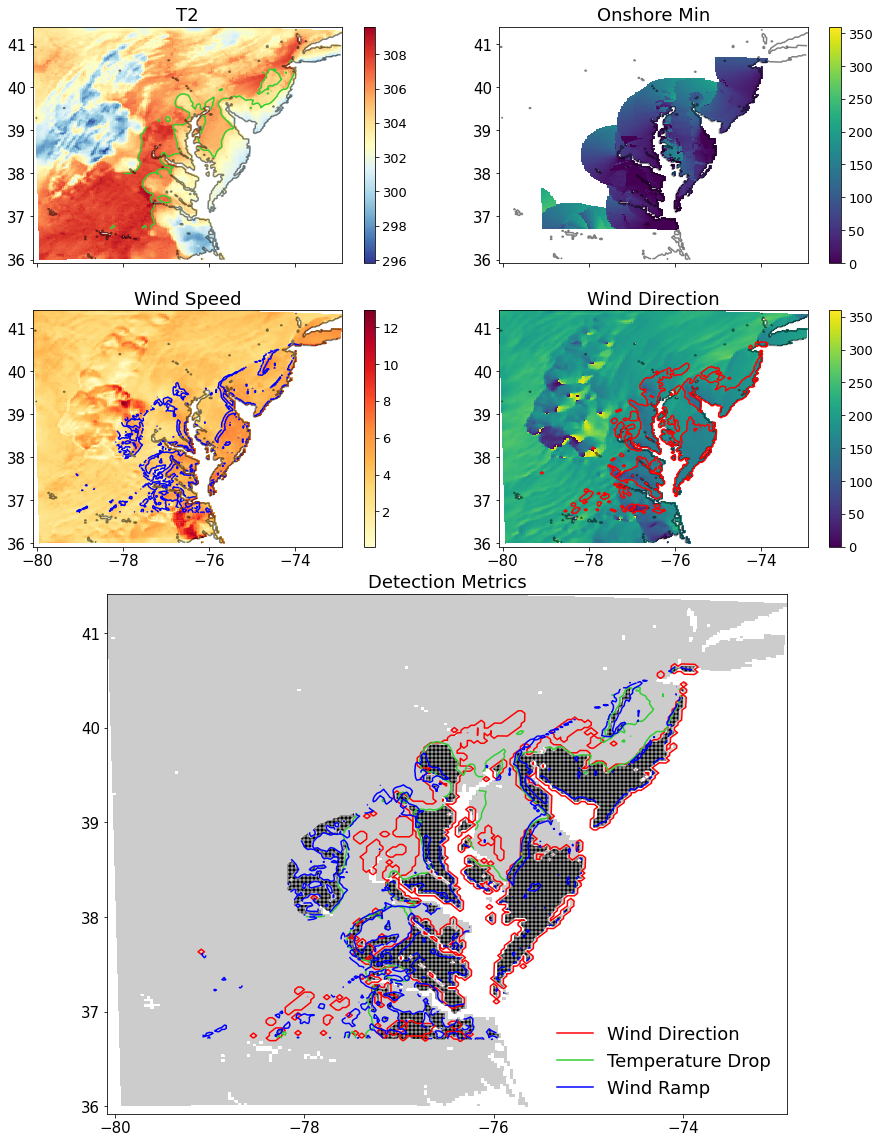

In [43]:
for ww,wrfout_file in enumerate(wrfout_files):
    wrfout = xr.open_dataset(wrfout_file)
    wrfout = np.squeeze(wrfout)
    if ww == 0:
        wrfinput = xr.open_dataset('{}{}/{}/wrfinput_d0{}'.format(wrf_dir,cases[0],restarts[0],case_dom[0]))
        land_mask  = np.squeeze(wrfinput.LANDMASK)
        hgt        = np.squeeze(wrfinput.HGT)
        water_mask = land_mask.copy().where(land_mask==0.0) + 1.0
        lat  = wrfout.XLAT
        lon  = wrfout.XLONG
        z_f = (np.squeeze(wrfout.PH) + np.squeeze(wrfout.PHB))/9.8 - np.squeeze(wrfout.HGT)
        zs_f = 0.5*(z_f[1:,:,:]+z_f[:-1,:,:])
    
    breeze_dict = spatial_breeze_check(onshore_min,
                                       onshore_max,
                                       wrfout,
                                       land_mask=land_mask)

    
    
    ds = convert_breeze_dict_to_xr(breeze_dict)
    
    if ww == 0:
        ds_f = ds.copy()
    else:
        ds_f = ds.combine_first(ds_f) 
    
    
    
    
    
    
    vel10,dir10 = calc_wind(wrfout,u='U10',v='V10')
    vel10 = vel10.where(land_mask == 1.0)
    dir10 = dir10.where(land_mask == 1.0)
    
    fig = plt.figure(figsize=(16,20))
    nrow,ncol = 4,4
    tmp_plt = plt.subplot2grid((nrow,ncol),(0,0),colspan=2,aspect='equal')
    tmp_plt_pc = tmp_plt.pcolormesh(lon,lat,wrfout.T2.where(land_mask == 1.0),cmap=plt.cm.RdYlBu_r)
    tmp_cbar = plt.colorbar(tmp_plt_pc,ax=tmp_plt)
    tmp_cbar.ax.tick_params(labelsize=13)
    tmp_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
    tmp_plt.contour(lon,lat,breeze_dict['dT'],levels=[0.0001],colors='limegreen')
    tmp_plt.tick_params(labelsize=15,labelbottom=False)
    tmp_plt.set_title('T2',size=18)


    vel_plt = plt.subplot2grid((nrow,ncol),(1,0),colspan=2,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
    vel_plt_pc = vel_plt.pcolormesh(lon,lat,vel10,cmap=plt.cm.YlOrRd)
    vel_cbar = plt.colorbar(vel_plt_pc,ax=vel_plt)
    vel_cbar.ax.tick_params(labelsize=13)
    vel_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
    vel_plt.contour(lon,lat,breeze_dict['dU'],levels=[0.5],colors='b')
    vel_plt.tick_params(labelsize=15)
    vel_plt.set_title('Wind Speed',size=18)

    ons_plt = plt.subplot2grid((nrow,ncol),(0,2),colspan=2,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
    ons_plt_pc = ons_plt.pcolormesh(lon,lat,onshore_min,cmap=plt.cm.viridis,norm=Normalize(0,360))
    ons_cbar = plt.colorbar(ons_plt_pc,ax=ons_plt)
    ons_cbar.ax.tick_params(labelsize=13)
    ons_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
    ons_plt.tick_params(labelsize=15,labelbottom=False)
    ons_plt.set_title('Onshore Min',size=18)

    dir_plt = plt.subplot2grid((nrow,ncol),(1,2),colspan=2,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
    dir_plt_pc = dir_plt.pcolormesh(lon,lat,dir10,cmap=plt.cm.viridis,norm=Normalize(0,360))
    dir_cbar = plt.colorbar(dir_plt_pc,ax=dir_plt)
    dir_cbar.ax.tick_params(labelsize=13)
    dir_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
    #dir_plt.contour(lon,lat,onshore_winds,levels=[1.0],colors='r')
    dir_plt.contour(lon,lat,breeze_dict['good_wdir'],levels=[1.0],colors='r')
    dir_plt.tick_params(labelsize=15)
    dir_plt.set_title('Wind Direction',size=18)


    crt_plt = plt.subplot2grid((nrow,ncol),(2,0),rowspan=2,colspan=4,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
    crt_plt_pc = crt_plt.pcolormesh(lon,lat,land_mask,cmap=plt.cm.binary,norm=Normalize(0,5.0))
    #plt.colorbar(crt_plt_pc,ax=crt_plt)
    crt_plt.contour(lon,lat,breeze_dict['good_wdir'],levels=[1.0],colors='r')
    crt_plt.contour(lon,lat,breeze_dict['dT'],levels=[0.0001],colors='limegreen')
    crt_plt.contour(lon,lat,breeze_dict['dU'],levels=[0.5],colors='b')
    crt_plt.plot(0.0,0.0,c='r',label='Wind Direction')
    crt_plt.plot(0.0,0.0,c='limegreen',label='Temperature Drop')
    crt_plt.plot(0.0,0.0,c='b',label='Wind Ramp')
    crt_plt.set_xlim(np.nanmin(lon),np.nanmax(lon))
    crt_plt.set_ylim(np.nanmin(lat),np.nanmax(lat))
    good_areas = crt_plt.contourf(lon,lat,breeze_dict['breeze'],levels=[1.9,4.1],colors='k',
                                  alpha=0.25,hatches=['+++', '/'],label='Test')
    artists, labels = good_areas.legend_elements()
    #crt_plt.legend(artists, ['Good Points'], handleheight=2)
    crt_plt.legend(frameon=False,fontsize=18,loc=4)
    crt_plt.tick_params(labelsize=15)
    crt_plt.set_title('Detection Metrics',size=18)

    plt.show()

# Save to NetCDF

In [71]:
ds_f.to_netcdf('{}{}/breeze_detection_d0{}.nc'.format(wrf_dir,cases[0],case_dom[0]))

/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'label'
  del sys.path[0]


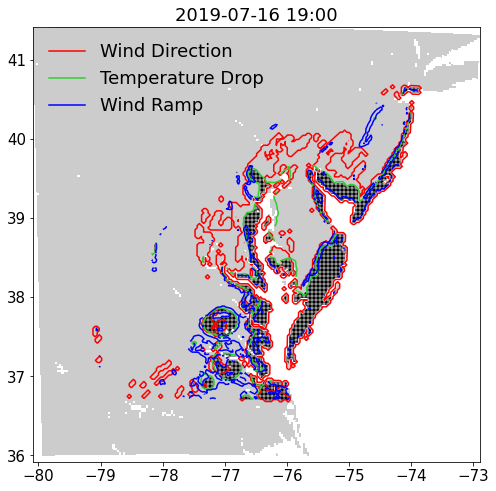

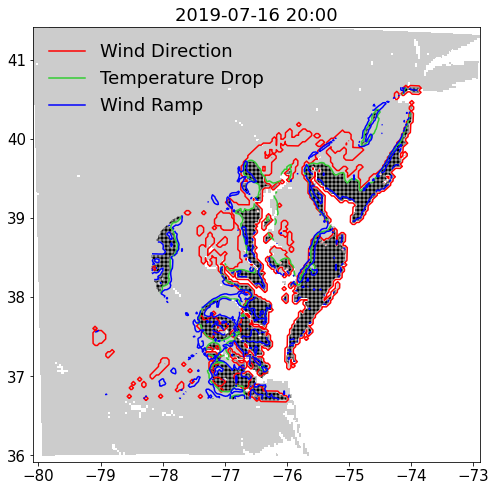

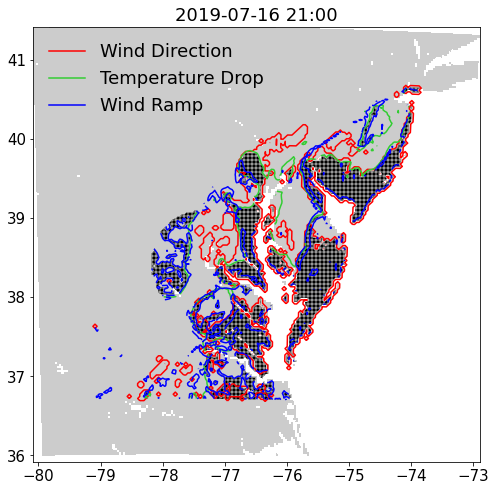

In [68]:
for time in ds_f.datetime:
    plt.figure(figsize=(8,8))
    plt.pcolormesh(lon,lat,land_mask,cmap=plt.cm.binary,norm=Normalize(0,5.0))
    plt.contour(lon,lat,ds_f.good_wdir.sel(datetime=time),levels=[1.0],colors='r')
    plt.contour(lon,lat,ds_f.dT.sel(datetime=time),levels=[0.0001],colors='limegreen')
    plt.contour(lon,lat,ds_f.dU.sel(datetime=time),levels=[0.5],colors='b')
    plt.plot(0.0,0.0,c='r',label='Wind Direction')
    plt.plot(0.0,0.0,c='limegreen',label='Temperature Drop')
    plt.plot(0.0,0.0,c='b',label='Wind Ramp')
    plt.xlim(np.nanmin(lon),np.nanmax(lon))
    plt.ylim(np.nanmin(lat),np.nanmax(lat))
    good_areas = plt.contourf(lon,lat,ds_f.breeze.sel(datetime=time),levels=[1.9,4.1],colors='k',
                                  alpha=0.25,hatches=['+++', '/'],label='Test')
    artists, labels = good_areas.legend_elements()
    #crt_plt.legend(artists, ['Good Points'], handleheight=2)
    plt.legend(frameon=False,fontsize=18,loc=2)
    plt.tick_params(labelsize=15)
    plt.title(date.strftime(pd.to_datetime(time.data),'%Y-%m-%d %H:%M'),size=18)
    plt.show()

/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the sam

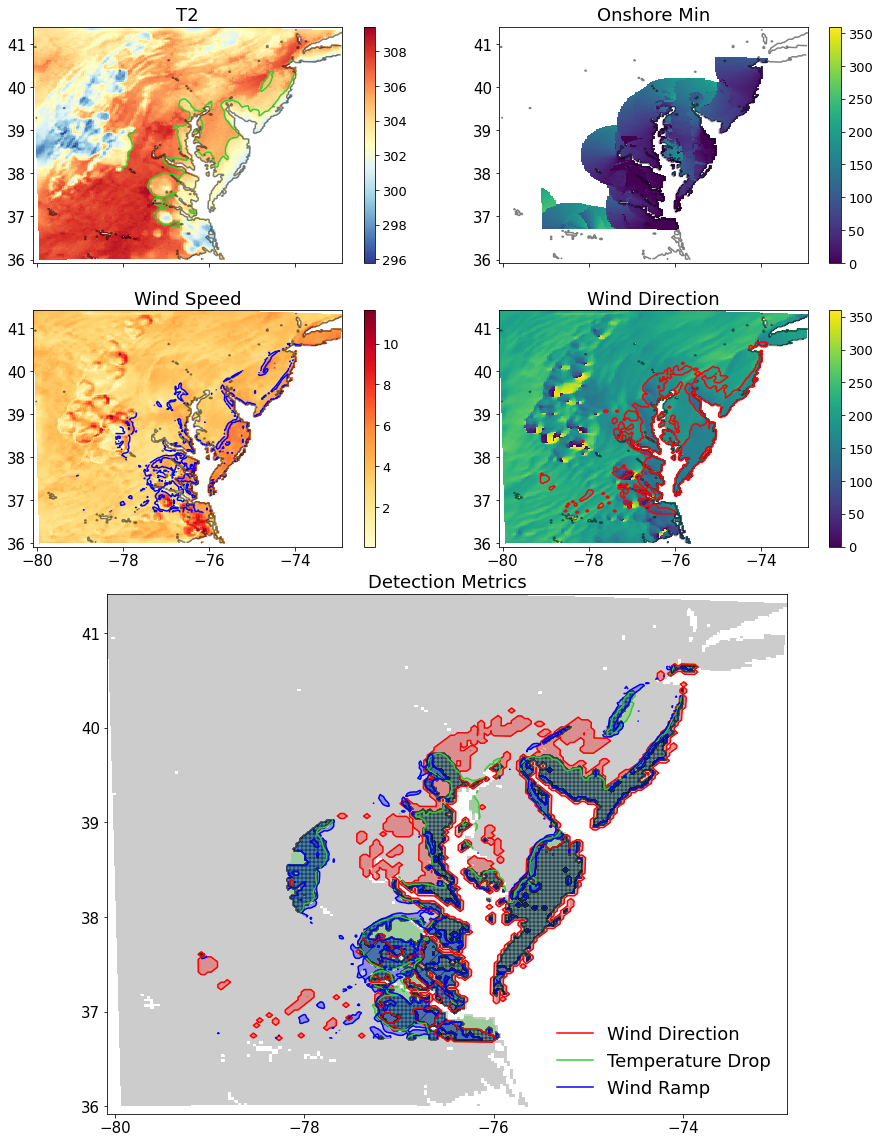

In [217]:
fig = plt.figure(figsize=(16,20))
nrow,ncol = 4,4

vel10,dir10 = calc_wind(wrfout,u='U10',v='V10')
vel10 = vel10.where(land_mask == 1.0)
dir10 = dir10.where(land_mask == 1.0)

tmp_plt = plt.subplot2grid((nrow,ncol),(0,0),colspan=2,aspect='equal')
tmp_plt_pc = tmp_plt.pcolormesh(lon,lat,wrfout.T2.where(land_mask == 1.0),cmap=plt.cm.RdYlBu_r)
tmp_cbar = plt.colorbar(tmp_plt_pc,ax=tmp_plt)
tmp_cbar.ax.tick_params(labelsize=13)
tmp_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
tmp_plt.contour(lon,lat,breeze_dict['dT'],levels=[0.0001],colors='limegreen')
tmp_plt.tick_params(labelsize=15,labelbottom=False)
tmp_plt.set_title('T2',size=18)


vel_plt = plt.subplot2grid((nrow,ncol),(1,0),colspan=2,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
vel_plt_pc = vel_plt.pcolormesh(lon,lat,vel10,cmap=plt.cm.YlOrRd)
vel_cbar = plt.colorbar(vel_plt_pc,ax=vel_plt)
vel_cbar.ax.tick_params(labelsize=13)
vel_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
vel_plt.contour(lon,lat,breeze_dict['dU'],levels=[0.5],colors='b')
vel_plt.tick_params(labelsize=15)
vel_plt.set_title('Wind Speed',size=18)

ons_plt = plt.subplot2grid((nrow,ncol),(0,2),colspan=2,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
ons_plt_pc = ons_plt.pcolormesh(lon,lat,onshore_min,cmap=plt.cm.viridis,norm=Normalize(0,360))
ons_cbar = plt.colorbar(ons_plt_pc,ax=ons_plt)
ons_cbar.ax.tick_params(labelsize=13)
ons_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
ons_plt.tick_params(labelsize=15,labelbottom=False)
ons_plt.set_title('Onshore Min',size=18)

dir_plt = plt.subplot2grid((nrow,ncol),(1,2),colspan=2,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
dir_plt_pc = dir_plt.pcolormesh(lon,lat,dir10,cmap=plt.cm.viridis,norm=Normalize(0,360))
dir_cbar = plt.colorbar(dir_plt_pc,ax=dir_plt)
dir_cbar.ax.tick_params(labelsize=13)
dir_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
#dir_plt.contour(lon,lat,onshore_winds,levels=[1.0],colors='r')
dir_plt.contour(lon,lat,breeze_dict['good_wdir'],levels=[1.0],colors='r')
dir_plt.tick_params(labelsize=15)
dir_plt.set_title('Wind Direction',size=18)


crt_plt = plt.subplot2grid((nrow,ncol),(2,0),rowspan=2,colspan=4,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
crt_plt_pc = crt_plt.pcolormesh(lon,lat,land_mask,cmap=plt.cm.binary,norm=Normalize(0,5.0))
#plt.colorbar(crt_plt_pc,ax=crt_plt)
crt_plt.contour(lon,lat,breeze_dict['good_wdir'],levels=[1.0],colors='r')
crt_plt.contour(lon,lat,breeze_dict['dT'],levels=[0.0001],colors='limegreen')
crt_plt.contour(lon,lat,breeze_dict['dU'],levels=[0.5],colors='b')

crt_plt.contourf(lon,lat,breeze_dict['good_wdir'],levels=[0.9,361],colors='r',alpha=0.3)
crt_plt.contourf(lon,lat,breeze_dict['dT'],levels=[0.0001,100.0],colors='limegreen',alpha=0.3)
crt_plt.contourf(lon,lat,breeze_dict['dU'],levels=[0.5,100.0],colors='b',alpha=0.3)
crt_plt.plot(0.0,0.0,c='r',label='Wind Direction')
crt_plt.plot(0.0,0.0,c='limegreen',label='Temperature Drop')
crt_plt.plot(0.0,0.0,c='b',label='Wind Ramp')
crt_plt.set_xlim(np.nanmin(lon),np.nanmax(lon))
crt_plt.set_ylim(np.nanmin(lat),np.nanmax(lat))
good_areas = crt_plt.contourf(lon,lat,breeze_dict['breeze'],levels=[1.1,2.2,3.1,4.1],colors='k',
                              hatches=['+++', '/'],alpha=0.5)

colors=['k','k']
for i, collection in enumerate(good_areas.collections):
    collection.set_edgecolor(colors[i % len(colors)])
    collection.set_facecolor(None)

artists, labels = good_areas.legend_elements()
#crt_plt.legend(artists, ['Good Points'], handleheight=2)
crt_plt.legend(frameon=False,fontsize=18,loc=4)
crt_plt.tick_params(labelsize=15)
crt_plt.set_title('Detection Metrics',size=18)

plt.show()

/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


A 97 130
B 85 125
D 86 132
E 85 128
C 119 92


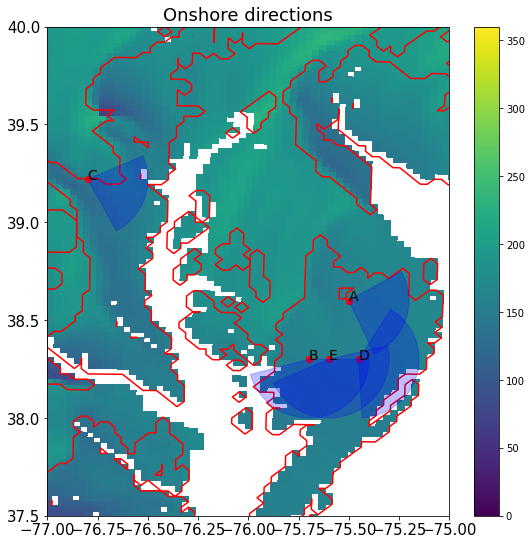

In [72]:
fig = plt.figure(figsize=(9,9))
hgt = hgt.where(land_mask == 1.0)
#hgt[np.where(land_mask==0.0)] = -100
plt.pcolormesh(lon,lat,dir10,
               #cmap=light_cmap,
               norm=Normalize(0,360)
              )
plt.colorbar()
plt.contour(lon,lat,breeze_dict['good_wdir'],levels=[1.0],colors='r')

plt.tick_params(labelsize=15)
plt.title('Onshore directions',size=18)

test_locs = {'A':{'lon':-75.5,
                  'lat':38.6},
             'B':{'lon':-75.7,
                  'lat':38.3},
             'D':{'lon':-75.45,
                  'lat':38.3},
             'E':{'lon':-75.6,
                  'lat':38.3},
             'C':{'lon':-76.8,
                  'lat':39.22}}

for ss,stn in enumerate(test_locs.keys()):
    stn_lon = test_locs[stn]['lon']
    stn_lat = test_locs[stn]['lat']
    
    dist_from_stn = ((lon-stn_lon)**2 + (lat-stn_lat)**2)**0.5
    stn_j,stn_i = np.where(dist_from_stn == np.nanmin(dist_from_stn))
    stn_j = int(stn_j)
    stn_i = int(stn_i)
    print(stn,stn_j,stn_i)


    x, y = stn_lon,stn_lat
    plt.scatter(x,y,c='r')
    

    pts  = np.arange(onshore_min[stn_j,stn_i],onshore_max[stn_j,stn_i],5.0)
    fill_c = 'b'

    npts = pts.size
    fill_x = [x]
    fill_y = [y]
    plt.scatter(x,y,c='r')
    for dd,wdir in enumerate(pts):
        d = 270.0 - wdir    # Convert met degrees to polar
        plt_dist = -0.3 # Met degrees are FROM dir... need negative distance!
        fill_x.append(x+plt_dist*np.cos(np.radians(d)))
        fill_y.append(y+plt_dist*np.sin(np.radians(d)))

    plt.fill(fill_x, fill_y,alpha=0.25,lw=None,color=fill_c,zorder=2)
    plt.text(x,y,stn,size=14)
plt.xlim(-77.0,-75.0)
plt.ylim(37.5,40.0)
plt.show()

# WORKING CODE:

In [199]:
# Maxiumum radius to look for water:
max_water_dist = 80.0
low_pct_0 = 95.0
upr_pct_0 = 5.0
max_deg_range = 180.0
show_plots = False

window_len = int(max_water_dist/dx)*2
half_window_len = int(window_len/2)
window_center = int((window_len)/2)
window_dist = ((xy[:window_len+1,:window_len+1] - xy[window_center,window_center])**2 + 
               (yx[:window_len+1,:window_len+1] - yx[window_center,window_center])**2)**0.5
window_dist[np.where(window_dist > max_water_dist)] = np.nan
window_filter = window_dist / window_dist

window_x,window_y = np.meshgrid(np.arange(0,np.shape(window_dist)[1]+1)*dy - max_water_dist - 1.5,
                                np.arange(0,np.shape(window_dist)[0]+1)*dx - max_water_dist - 1.5)

window_deg = -1*(180.0*np.arctan(((yx[:window_len+1,:window_len+1] - yx[window_center,window_center])/
                     (xy[:window_len+1,:window_len+1] - xy[window_center,window_center])))/(np.pi) - 90.0)
window_deg[:,:half_window_len] = window_deg[:,:half_window_len] + 180.0
window_deg[np.where(np.isnan(window_dist))] = np.nan

math_deg = 180.0*np.arctan(((yx[:window_len+1,:window_len+1] - yx[window_center,window_center])/
                     (xy[:window_len+1,:window_len+1] - xy[window_center,window_center])))/(np.pi)
math_deg[:,:half_window_len] = math_deg[:,:half_window_len] + 180.0
math_deg[:half_window_len,half_window_len:] = 360 + math_deg[:half_window_len,half_window_len:]
math_deg[np.where(np.isnan(window_dist))] = np.nan


onshore_min = np.zeros((ny,nx))*np.nan
onshore_max = np.zeros((ny,nx))*np.nan
for ii in np.arange(half_window_len,nx-half_window_len):
    for jj in np.arange(half_window_len,ny-half_window_len): 
#for ii in np.arange(125,126): #98
#    for jj in np.arange(85,86): #87
        if land_mask[jj,ii] == 1.0:
            loc_water_mask = water_mask[jj-half_window_len:jj+half_window_len+1, ii-half_window_len:ii+half_window_len+1]
            dist_water = loc_water_mask * window_dist
            deg_water  = loc_water_mask * window_deg

            # Break down the water bodies into groups:
            water_bodies = skimage.morphology.label(~np.isnan(deg_water)).astype(np.float32)
            water_bodies[water_bodies==0.0] = np.nan
            
            water_body_size = {}
            water_body_dist = {}
            min_water_distance = 999.9
            closest_water_body = 0.0
            
            # If we have water bodies to check, enter loop:
            if ~np.all(np.isnan(water_bodies)): 
                for i in np.arange(1.0,np.nanmax(water_bodies)+1.0): # Loop over all identified water bodies
                    water_size = len(water_bodies[water_bodies==i])
                    if water_size < 8: # Only check for large bodies
                        water_bodies[water_bodies==i] = np.nan
                    else:
                        water_body_size[i] = water_size
                        water_body = water_bodies.copy()
                        water_body[water_bodies!=i] = np.nan # Check only this water body
                        water_body[~np.isnan(water_body)] = 1.0 # Set values to 1 to get mask for distance calculation
                        water_body_min_dist = np.nanpercentile(water_body*dist_water,50)
                        water_body_dist[i] = water_body_min_dist

                # Small water bodies were removed, check to see if there were any large ones:
                if ~np.all(np.isnan(water_bodies)):
                    # Find the largest and closest water bodies:
                    largest_water_body = max(water_body_size,key=water_body_size.get)
                    closest_water_body = min(water_body_dist,key=water_body_size.get)
                    if largest_water_body == closest_water_body:
                        water_body_id = largest_water_body
                    else: # Largest is not closest:
                        size_of_closest = water_body_size[closest_water_body]
                        dist_of_closest = water_body_dist[closest_water_body]
                        size_of_largest = water_body_size[largest_water_body]
                        dist_of_largest = water_body_dist[largest_water_body]
                        # Lean towards the largest body:
                        if (size_of_closest/size_of_largest) < 0.90:
                            water_body_id = largest_water_body
                        else: # If they're about the same size, pick the closest
                            water_body_id = closest_water_body
                        
                     
                    for i in np.arange(np.nanmin(water_bodies),np.nanmax(water_bodies)+1.0):
                        if i != water_body_id:
                            water_bodies[water_bodies==i] = np.nan
                    water_bodies[water_bodies==water_body_id] = 1.0

                    deg_water *= water_bodies

                    deg_range = float(np.nanmax(deg_water)) - float(np.nanmin(deg_water))
                    if deg_range > 300:
                        deg_water[np.where(deg_water>300)] -= 360.0
                    # Set limits for upper and lower bounds.
                    # If range is too big (> max_deg_range) then we iterate by 5 degrees
                    # ... on the upper and lower limits until the range is sufficient.
                    if np.nanmax(water_bodies) > 0:
                        good_lims = False
                        low_pct = low_pct_0
                        upr_pct = upr_pct_0
                        while good_lims == False:
                            lowr_lim = np.nanpercentile(deg_water,low_pct)
                            uppr_lim = np.nanpercentile(deg_water,upr_pct)
                            if lowr_lim - uppr_lim < max_deg_range:
                                good_lims = True
                            else:
                                low_pct -= 5.0
                                upr_pct += 5.0                                
                    else: # Set ones where water_bodies is all nan to nan
                        lowr_lim = np.nan
                        uppr_lim = np.nan
                    onshore_min[jj,ii] = uppr_lim 
                    onshore_max[jj,ii] = lowr_lim


                if show_plots:
                    lwr_xe = max_water_dist*np.cos(np.radians(convert_met_to_math(lowr_lim)))
                    lwr_ye = max_water_dist*np.sin(np.radians(convert_met_to_math(lowr_lim)))
                    upr_xe = max_water_dist*np.cos(np.radians(convert_met_to_math(uppr_lim)))
                    upr_ye = max_water_dist*np.sin(np.radians(convert_met_to_math(uppr_lim)))

                    mid_xe = max_water_dist*np.cos(np.radians(convert_met_to_math(np.nanmedian(deg_water))))
                    mid_ye = max_water_dist*np.sin(np.radians(convert_met_to_math(np.nanmedian(deg_water))))

                    fig = plt.figure(figsize=(12,9))
                    lm_pltF = plt.subplot2grid((2,2),(0,0),aspect='equal')
                    plt_landmask = lm_pltF.pcolormesh(lon,lat,land_mask.where(land_mask==0.0))#,levels=[0.5],colors='k')
                    lm_pltF.scatter(lon[jj,ii],lat[jj,ii],facecolor='b',marker='*',s=200)
                    lm_pltF.tick_params(labelsize=15)
                    lm_pltF.set_xlabel('Longitude',size=18)
                    lm_pltF.set_ylabel('Latitude',size=18)

                    lm_plt = plt.subplot2grid((2,2),(0,1),aspect='equal')
                    plt_landmask = lm_plt.pcolormesh(window_x,window_y,loc_water_mask,norm=Normalize(0,max_water_dist))
                    plt.colorbar(plt_landmask,ax=lm_plt)
                    lm_plt.scatter(0,0,facecolor='b',marker='*',s=400)
                    lm_plt.set_xlim(np.nanmin(window_x)-5.0,np.nanmax(window_x)+5.0)
                    lm_plt.set_ylim(np.nanmin(window_y)-5.0,np.nanmax(window_y)+5.0)
                    lm_plt.tick_params(labelsize=15)
                    lm_plt.set_ylabel('Distance [km]',size=18)

                    dist_plt = plt.subplot2grid((2,2),(1,0),aspect='equal')
                    dist_plt_cm = dist_plt.pcolormesh(window_x,window_y,dist_water,norm=Normalize(0,max_water_dist))
                    plt.colorbar(dist_plt_cm,ax=dist_plt)
                    dist_plt.scatter(0,0,facecolor='b',marker='*',s=400)
                    dist_plt.set_xlim(np.nanmin(window_x)-5.0,np.nanmax(window_x)+5.0)
                    dist_plt.set_ylim(np.nanmin(window_y)-5.0,np.nanmax(window_y)+5.0)
                    dist_plt.tick_params(labelsize=15)
                    dist_plt.set_xlabel('Distance [km]',size=18)
                    dist_plt.set_ylabel('Distance [km]',size=18)

                    deg_plt = plt.subplot2grid((2,2),(1,1),aspect='equal')
                    deg_plt_cm = deg_plt.pcolormesh(window_x,window_y,deg_water)#,norm=Normalize(0,360))
                    plt.colorbar(deg_plt_cm,ax=deg_plt)
                    deg_plt.plot([0,lwr_xe,upr_xe,0],[0,lwr_ye,upr_ye,0],c='r')
                    deg_plt.plot([0,mid_xe],[0,mid_ye],c='g')
                    deg_plt.scatter(0,0,facecolor='b',marker='*',s=400,zorder=5)
                    ##ax[0].plot([0,upr_xe],[0,upr_ye],c='r')
                    #deg_plt = ax[1].pcolormesh(window_x,window_y,deg_water)#,norm=Normalize(0,360))
                    #plt.colorbar(deg_plt,ax=ax[1])
                    deg_plt.set_xlim(np.nanmin(window_x)-5.0,np.nanmax(window_x)+5.0)
                    deg_plt.set_ylim(np.nanmin(window_y)-5.0,np.nanmax(window_y)+5.0)
                    deg_plt.tick_params(labelsize=15)
                    deg_plt.set_xlabel('Distance [km]',size=18)
                    plt.show()
                    wefwef


/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
